In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2
from argparse import Namespace

import common.loss_utils as loss_utils
import sys
sys.path.append("RAFT/core")

from raft import RAFT
from utils.utils import InputPadder

In [4]:
args = Namespace(
    model='RAFT/models/raft-kitti.pth',
    small=False,
    mixed_precision=False,
    alternate_corr=False,
)

In [5]:
model = torch.nn.DataParallel(RAFT(args))

In [6]:
model.load_state_dict(torch.load(args.model))

<All keys matched successfully>

In [7]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [8]:
model = model.module
model.to(DEVICE)
model = model.eval()

In [9]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [10]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [11]:
def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

In [12]:

class DataFetcher:
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
#         rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
#         rand_y = self.generator.randint(0, input_slice.shape[1] - 128)
        rand_x = (input_slice.shape[2] - 128) // 2
        rand_y = (input_slice.shape[1] - 128) // 2

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data)

In [13]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [14]:
x, y = ds[0]

In [15]:
x.shape, y.shape

((12, 128, 128), (24, 64, 64))

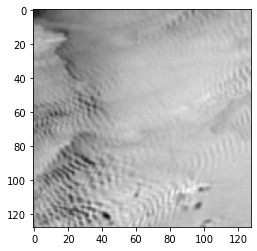

In [16]:
plt.imshow(x[0], cmap='gray')

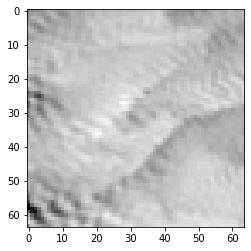

In [17]:
plt.imshow(y[0], cmap='gray')

In [22]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def get_mssim(y, x, average=True):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    if average:
        mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
        yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
        xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
        return 1.0 - mssim_loss(
            torch.Tensor(yd),
            torch.Tensor(xd),
        ).item()
    else:
        ret = []
        for i in range(y.shape[0]):
            score = get_mssim(y[i], x[i])
            ret.append(score)
        return ret

In [19]:
LOOKS = 500


In [20]:
def preprocess(x):
    x = x.astype(np.float32)*255.0/1023.0
    # add an RGB channel
    x = np.expand_dims(x, axis=0)
    x = np.tile(x, (3, 1, 1))
    # add a batch dimension
    x = np.expand_dims(x, axis=0)
    return torch.Tensor(x).float().to(DEVICE)

In [23]:
pers_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = x[-1:,32:96,32:96]
    preds = np.tile(preds, (y.shape[0], 1, 1))
    score = get_mssim(preds, y, average=False)
    pers_scores.append(score)

100%|██████████| 500/500 [00:17<00:00, 27.95it/s]


In [25]:
pers_scores = np.array(pers_scores)

In [27]:
np.mean(pers_scores)

0.6110033917327722

In [51]:
step_means = np.mean(pers_scores, axis=0)
step_stds = np.std(pers_scores, axis=0)

In [52]:
step_means

array([0.88632703, 0.79344851, 0.73701968, 0.69713032, 0.66866749,
       0.64714347, 0.63203021, 0.62027657, 0.60863207, 0.59665385,
       0.58735347, 0.57964784, 0.57380448, 0.56907231, 0.5645283 ,
       0.5587864 , 0.55347086, 0.54994471, 0.54605208, 0.54237107,
       0.54028794, 0.54043592, 0.53741777, 0.53357904])

In [53]:
# coefficient of variance
step_stds / step_means

array([0.10713402, 0.18544097, 0.22885087, 0.26355636, 0.28977038,
       0.30860654, 0.32336437, 0.33555674, 0.34729068, 0.36148124,
       0.3705684 , 0.3775105 , 0.38246513, 0.38379825, 0.38685808,
       0.39427834, 0.40554115, 0.40962933, 0.41344997, 0.41762635,
       0.41789684, 0.41266738, 0.41777917, 0.42081024])

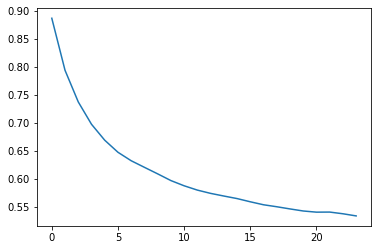

In [34]:
plt.plot(range(24), step_means)

In [113]:
# vanilla blur
forecast = 24
vanilla_blur_optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    with torch.no_grad():
        _, flow = model(prev, cur, iters=20, test_mode=True)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(forecast):
        cur = warp_flow(cur, flow)
        cur = cv2.blur(cur, (3, 3))
        preds[j] = cur[32:96,32:96]
    remaining = 24 - forecast
    if remaining > 0:
        preds[forecast:] = cur[32:96,32:96]
    score = get_mssim(preds, y, average=False)
    vanilla_blur_optical_flow_scores.append(score)

100%|██████████| 500/500 [00:41<00:00, 12.00it/s]


In [114]:
vanilla_blur_optical_flow_scores = np.array(vanilla_blur_optical_flow_scores)
vanilla_blur_step_means = np.mean(vanilla_blur_optical_flow_scores, axis=0)
vanilla_blur_step_stds = np.std(vanilla_blur_optical_flow_scores, axis=0)

In [115]:
np.mean(vanilla_blur_optical_flow_scores)

0.667334574903051

In [116]:
vanilla_blur_step_means

array([0.93084739, 0.8671757 , 0.81814733, 0.77827905, 0.74656775,
       0.7203157 , 0.69895047, 0.68070395, 0.66517063, 0.65205182,
       0.64113396, 0.63178115, 0.62162327, 0.61345665, 0.60769835,
       0.60292111, 0.59799999, 0.59565883, 0.59454691, 0.59368868,
       0.59219731, 0.5905433 , 0.58792506, 0.58664545])

In [110]:
new_preds = preds.copy()
idx = 12
new_preds[idx:] = new_preds[idx - 1]

In [123]:
# mean predictors
mean_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = np.ones(y.shape) * np.mean(x[-1])
    score = get_mssim(preds, y, average=False)
    mean_scores.append(score)

100%|██████████| 500/500 [00:18<00:00, 27.19it/s]


In [124]:
mean_scores = np.array(mean_scores)
mean_step_means = np.mean(mean_scores, axis=0)
mean_step_stds = np.std(mean_scores, axis=0)

In [121]:
np.mean(mean_scores)

0.6042381940335035

In [122]:
mean_step_means

array([0.5947131 , 0.59389063, 0.59395108, 0.59346445, 0.59351096,
       0.5938146 , 0.59496706, 0.59593715, 0.59676564, 0.59817109,
       0.5988576 , 0.59975199, 0.60089719, 0.6023338 , 0.60425414,
       0.60672175, 0.60891842, 0.61171989, 0.61429426, 0.61655514,
       0.61863497, 0.62109328, 0.62344837, 0.62505008])

In [59]:
# vanilla
vanilla_optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    with torch.no_grad():
        _, flow = model(prev, cur, iters=20, test_mode=True)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        cur = warp_flow(cur, flow)
        preds[j] = cur[32:96,32:96]
    score = get_mssim(preds, y, average=False)
    vanilla_optical_flow_scores.append(score)

100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


In [55]:
vanilla_optical_flow_scores = np.array(vanilla_optical_flow_scores)
vanilla_step_means = np.mean(vanilla_optical_flow_scores, axis=0)
vanilla_step_stds = np.std(vanilla_optical_flow_scores, axis=0)

In [42]:
np.mean(vanilla_optical_flow_scores)

0.6386402233590682

In [39]:
vanilla_step_means

array([0.93150687, 0.86280021, 0.80864567, 0.76393273, 0.72793967,
       0.69758633, 0.67205258, 0.65119782, 0.63354609, 0.61880442,
       0.60614236, 0.59507586, 0.58517213, 0.57868533, 0.57502454,
       0.56991001, 0.56489254, 0.5620604 , 0.55919285, 0.55611143,
       0.55485261, 0.55275859, 0.55078014, 0.54869421])

In [46]:
# variance
vanilla_step_stds / vanilla_step_means

array([0.06990363, 0.11027508, 0.14625198, 0.18081303, 0.21217706,
       0.23953782, 0.26932449, 0.29177413, 0.31161213, 0.33168799,
       0.34956369, 0.36461794, 0.3787719 , 0.38385811, 0.38496046,
       0.39523912, 0.4041423 , 0.40645506, 0.40948762, 0.41461214,
       0.41404818, 0.41664661, 0.42109776, 0.42485556])

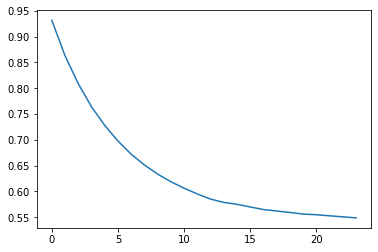

In [40]:
plt.plot(range(24), vanilla_step_means)

In [62]:
# classical
params = {
    'iterations': 1,
      'levels': 10,
      'poly_n': 2,
      'poly_sigma': 1.3358462139572997,
      'pyr_scale': 0.13581496550086464,
      'winsize': 3
}
classical_optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    flow = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        **params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        cur = warp_flow(cur, flow)
        cur = cv2.blur(cur, (3, 3))
        preds[j] = cur[32:96,32:96]
    score = get_mssim(preds, y, average=False)
    classical_optical_flow_scores.append(score)

100%|██████████| 500/500 [00:19<00:00, 25.87it/s]


In [63]:
classical_optical_flow_scores = np.array(classical_optical_flow_scores)

In [66]:
classical_step_means = np.mean(classical_optical_flow_scores, axis=0)
classical_step_stds = np.std(classical_optical_flow_scores, axis=0)

In [65]:
classical_step_means

array([0.89724101, 0.83654741, 0.79556637, 0.76562703, 0.74292023,
       0.72516605, 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [68]:
# variance
classical_step_stds / classical_step_means

array([0.08796528, 0.13119763, 0.16052233, 0.1831536 , 0.20072331,
       0.21457233, 0.2290726 , 0.23812938, 0.24729417, 0.25742963,
       0.2647005 , 0.27214644, 0.27916121, 0.28418854, 0.29036532,
       0.2972955 , 0.30066129, 0.30160546, 0.30589016, 0.30825234,
       0.30944434, 0.30954027, 0.31125873, 0.31305329])

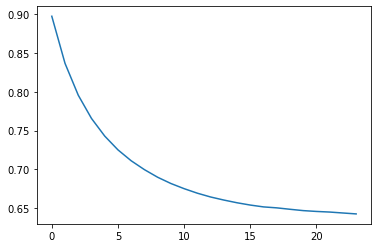

In [69]:
plt.plot(range(24), classical_step_means)

In [78]:
# combine opt flow with classical
combined_optical_flow_scores = []
forecast = 3
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    with torch.no_grad():
        _, flow = model(prev, cur, iters=20, test_mode=True)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(forecast):
        cur = warp_flow(cur, flow)
        preds[j] = cur[32:96,32:96]
    remaining = 24 - forecast
    # mix with classical opt flow
    if remaining > 0:
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[-2],
            next=x[-1],
            flow=None,
            **params,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        cur = x[-1].astype(np.float32)
        for j in range(24):
            cur = warp_flow(cur, flow)
            cur = cv2.blur(cur, (3, 3))
            if j < forecast:
                continue
            preds[j] = cur[32:96,32:96]

    score = get_mssim(preds, y, average=False)
    combined_optical_flow_scores.append(score)
    

100%|██████████| 500/500 [00:43<00:00, 11.60it/s]


In [79]:
combined_optical_flow_scores = np.array(combined_optical_flow_scores)
combined_step_means = np.mean(combined_optical_flow_scores, axis=0)
combined_step_stds = np.std(combined_optical_flow_scores, axis=0)

In [80]:
np.mean(combined_optical_flow_scores)

0.6989704031795263

In [81]:
combined_step_means

array([0.93150687, 0.86280021, 0.80864567, 0.76562703, 0.74292023,
       0.72516605, 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [82]:
# variance
combined_step_stds / combined_step_means

array([0.06990363, 0.11027508, 0.14625198, 0.1831536 , 0.20072331,
       0.21457233, 0.2290726 , 0.23812938, 0.24729417, 0.25742963,
       0.2647005 , 0.27214644, 0.27916121, 0.28418854, 0.29036532,
       0.2972955 , 0.30066129, 0.30160546, 0.30589016, 0.30825234,
       0.30944434, 0.30954027, 0.31125873, 0.31305329])

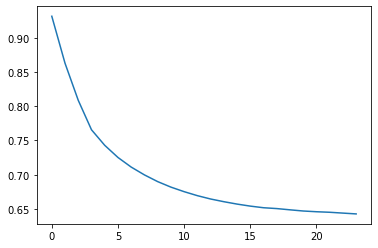

In [83]:
plt.plot(range(24), combined_step_means)

In [174]:
# chained flow
optical_flow_scores = []
pbar = tqdm.tqdm(range(LOOKS))
for i in pbar:
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    cur_img = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        with torch.no_grad():
            _, flow = model(prev, cur, iters=20, test_mode=True)
        flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
        cur_img = warp_flow(cur_img, flow)
        preds[j] = cur_img[32:96,32:96]
        prev = cur
        cur = preprocess(cur_img)
    
    score = get_mssim(preds, y)
    optical_flow_scores.append(score)
    
    avg = round(np.mean(optical_flow_scores), 4)
    pbar.set_description(f'Avg: {avg}')
    

In [80]:
np.mean(optical_flow_scores)

0.6386402350664139

In [89]:
# vanilla, multiply
vanilla_mult_optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    with torch.no_grad():
        _, flow = model(prev, cur, iters=20, test_mode=True)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        nxt = warp_flow(cur, flow*(j+1))
        preds[j] = nxt[32:96,32:96]
    score = get_mssim(preds, y, average=False)
    vanilla_mult_optical_flow_scores.append(score)

100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


In [90]:
vanilla_mult_optical_flow_scores = np.array(vanilla_mult_optical_flow_scores)
vanilla_mult_step_means = np.mean(vanilla_mult_optical_flow_scores, axis=0)
vanilla_mult_step_stds = np.std(vanilla_mult_optical_flow_scores, axis=0)

In [91]:
np.mean(vanilla_mult_optical_flow_scores)

0.6129028458694616

In [92]:
vanilla_mult_step_means

array([0.93150687, 0.85983066, 0.80188046, 0.75364492, 0.71452081,
       0.68050266, 0.65218617, 0.62966314, 0.60976299, 0.5926115 ,
       0.57893258, 0.56595396, 0.55510661, 0.54724198, 0.5416337 ,
       0.53522374, 0.52987964, 0.52597556, 0.52278911, 0.51944775,
       0.51824512, 0.51632288, 0.51432736, 0.51247813])

In [51]:
# flow on top of flow?
optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    flow_up = None
    with torch.no_grad():
        for j in range(0, 11):
            prev = preprocess(x[j])
            cur = preprocess(x[j + 1])
            flow_up, flow = model(prev, cur, iters=20, test_mode=True, flow_init=flow_up)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        nxt = warp_flow(cur, flow*(j+1))
        preds[j] = nxt[32:96,32:96]
    score = get_mssim(preds, y)
    optical_flow_scores.append(score)

100%|██████████| 500/500 [04:32<00:00,  1.84it/s]


In [52]:
np.mean(optical_flow_scores)

0.6070924097299576

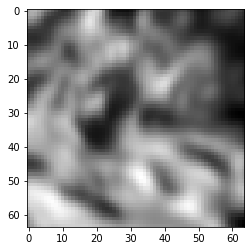

In [83]:
plt.imshow(preds[14], cmap='gray')

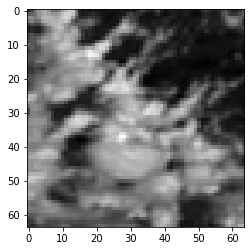

In [84]:
plt.imshow(y[14], cmap='gray')

In [68]:
get_mssim(preds_classical[sl], y[sl])

0.1377885341644287

In [69]:
get_mssim(preds_classical_blur[sl], y[sl])

0.13868707418441772